# IDEB -  Clusterização e previsão de fatores mais influentes

## Variáveis
##### Todos os valores são referentes ao ensino médio da rede pública estadual

**id_municipio**: Identificador de sete dígitos do IBGE<br>
**uf**: Sigla da unidade da federação do estado<br>
**nome_município**: Nome do município conforme nomenclatura do IBGE<br>
**ideb_2017**: Valor observado do IDEB para o município<br>
**aluno_turma**: Número de alunos por turma (média)<br>
**hora_aula**: Número de aulas por dia (média)<br>
**prof_cs**: Professores com formação superior (percentual)<br>
**aprovacao**: Taxa de aprovação (média percentual)<br>
**reprovacao**: Taxa de reprovação (média percentual)<br>
**abandono**: Taxa de abandono escolar, caracterizado pelo abandono e retorno à IE (média percentual)<br>
**distorcao**: Distorção idade-série (média percentual)<br>
**promocao**: Taxa de promoção para o ano seguinte, continuada ou não (média percentual)<br>
**repetencia**: Taxa de repetência (média percentual)<br>
**evasao**: Taxa de abandono escolar, caracterizado pela evasão e não retorno à IE (média percentual)<br>
**migracao_eja**: Taxa de migração para a EJA (média percentual)<br>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [114]:
pd.options.display.max_rows = 100

In [3]:
#Carregamento e processamento dos dados do IDEB por cidade
df = pd.read_excel('divulgacao_ensino_medio_municipios_2019.xlsx')
df = df.drop(df.index[:8])
df = df.drop(df.index[11634:])
df = df.rename(columns=df.iloc[0])
df = df.drop(df.index[0])
df = df[df.REDE == 'Estadual']
df = df.drop(df.columns[5:22], axis=1)
df = df.drop(['VL_APROVACAO_2017_SI_4', 'VL_OBSERVADO_2019', 'VL_PROJECAO_2019', 'VL_PROJECAO_2021'], axis=1)
df.columns = ('uf', 'id_municipio', 'nome_municipio', 'rede', 'ideb_2017')

In [17]:
#Remoção das cidades sem valor do IDEB
df_sem_vf = df[df.ideb_2017 != '-']

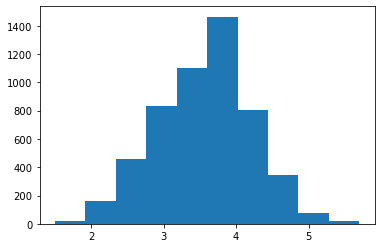

In [18]:
fig = plt.hist(x=df_sem_vf.ideb_2017)

In [19]:
#Alunos por turma (média)
aturma = pd.read_excel('ATU_MUNICIPIOS_2017.xlsx')
aturma = aturma.rename(columns=aturma.iloc[0]) 
aturma = aturma.iloc[1:] 
aturma.columns=['uf', 'id_municipio', 'nome_municipio', 'local', 'rede', 'aluno_turma']
aturma = aturma.iloc[:-3]
aturma = aturma[aturma.local == 'Total']
aturma = aturma[aturma.rede == 'Estadual']
df_final = pd.merge(df_sem_vf,aturma,on='id_municipio')

In [25]:
#Horas de aula por dia(média)
hora_aula = pd.read_excel('HAD_MUNICIPIOS_2017.xlsX')
hora_aula.columns=['uf', 'id_municipio', 'nome_municipio', 'local', 'rede', 'hora_aula']
hora_aula = hora_aula[hora_aula.local == 'Total']
hora_aula = hora_aula[hora_aula.rede == 'Estadual']
df_final = pd.merge(df_final,hora_aula,on='id_municipio')

In [33]:
#Professores com curso superior (percentual)
prof_cs = pd.read_excel('DSU_MUNICIPIOS_2017.xlsx')
prof_cs.columns=['uf', 'id_municipio', 'nome_municipio', 'local', 'rede', 'prof_cs']
prof_cs = prof_cs[prof_cs.local == 'Total']
prof_cs = prof_cs[prof_cs.rede == 'Estadual']
df_final = pd.merge(df_final,prof_cs,on='id_municipio')

In [40]:
df_final = df_final[['uf_x', 'local_x', 'rede_x', 'id_municipio', 
                     'nome_municipio_x', 'ideb_2017', 'aluno_turma', 'hora_aula', 'prof_cs']]
df_final = pd.read_excel('dados.xlsx')
df_final.columns = ['uf', 'local', 'rede', 'id_municipio', 'nome_municipio', 'ideb_2017', 
                    'aluno_turma', 'hora_aula', 'prof_cs']

In [46]:
#Taxas de rendimento - aprovação, reprovação e abandono escolar (percentual)
rendimento = pd.read_excel('TX_REND_MUNICIPIOS_2017.xlsx')
rendimento.columns = ['uf', 'id_municipio', 'nome_municipio','local', 'rede', 'aprovacao', 'reprovacao', 'abandono']
rendimento = rendimento[rendimento.local == 'Total']
rendimento = rendimento[rendimento.rede == 'Estadual']
    
del rendimento['uf']
del rendimento['nome_municipio']
del rendimento['local']
del rendimento['rede']

df_final = pd.merge(df_final,rendimento,on='id_municipio')

del df_final['local']
del df_final['rede']

In [56]:
#Distorção idade-série (percentual)
distorcao = pd.read_excel('TDI_MUNICIPIOS_2017.xlsx')
distorcao = distorcao[distorcao.local == 'Total']
distorcao = distorcao[distorcao.rede == 'Estadual']

del distorcao['local']
del distorcao['rede']

df_final = pd.merge(df_final,distorcao,on='id_municipio')

In [57]:
#Taxas de transição
transicao = pd.read_excel('TX_TRANSICAO_MUNICIPIOS_2017_2018.xlsx')
transicao = transicao.iloc[:-3]
transicao = transicao[transicao.local == 'Total']
transicao = transicao[transicao.rede == 'Pública']

del transicao['local']
del transicao['uf']
del transicao['nome_municipio']

df_final = pd.merge(df_final,transicao,on='id_municipio')

del df_final['rede']

In [58]:
#Exportação da tabela final
df_final.to_csv('dados_educacao_2017.csv')
df_final.to_excel('dados_educacao_2017.xlsx')

In [177]:
#Criação de vetor alvo (IDEB) e matriz com variáveis
X = df_final.drop('ideb_2017', axis=1)
y = df_final['ideb_2017']

In [94]:
#Criação da tabela final com coordenadas dos município
coordenadas = pd.read_csv('coordenadas_municipios.csv')

del coordenadas['codigo_uf']
del coordenadas['capital']

coordenadas.columns = ['id_municipio', 'municipio', 'latitude', 'longitude']
df_final = pd.merge(df_final,coordenadas,on='id_municipio')

del df_final['municipio']

#Exportação da tabela final com coordenadas dos município
df_final.to_csv('df_final_coordenadas.csv')


del df_final['latitude']
del df_final['longitude']

In [125]:
df_final_kmeans = df_final

### Dados não-escalonados (MinMax)

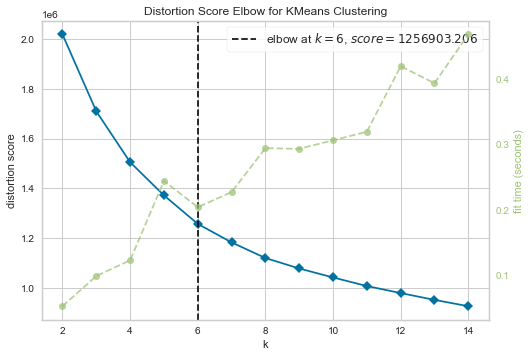

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [203]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15))

visualizer.fit(X)       
visualizer.show()    

C:\Users\Lucas\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Lucas\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Lucas\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


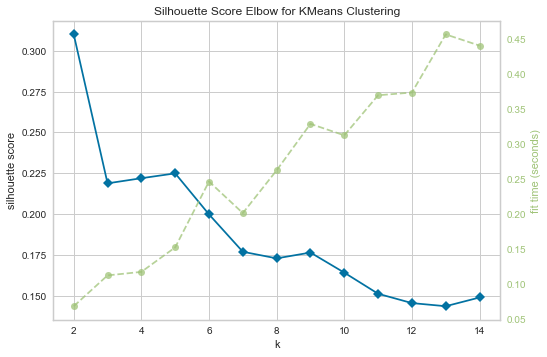

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [212]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15), metric='silhouette')

visualizer.fit(X) 
visualizer.show()       

In [204]:
#Escalonamento dos dados da matriz X
scaler = MinMaxScaler()
X_scal = scaler.fit_transform(X)

### Dados escalonados (MinMax)

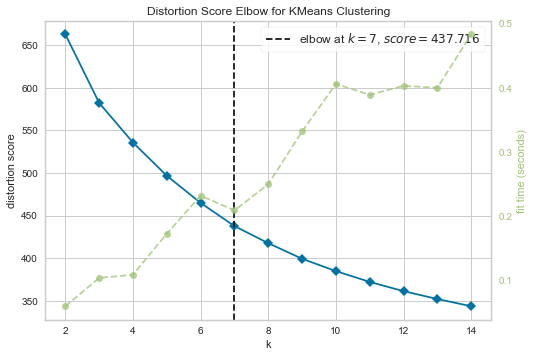

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [211]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15), metric='distortion')

visualizer.fit(X_scal)   
visualizer.show()      

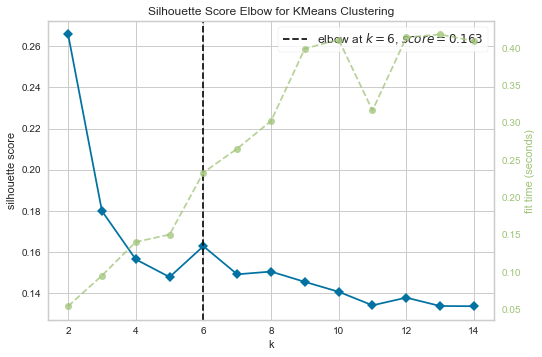

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [209]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15), metric='silhouette')

visualizer.fit(X_scal)   
visualizer.show()        